In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D
import torch.optim as optim
from matplotlib import pyplot as plt
import numpy as np

In [18]:
latent_size = 256 # compression = 256*256/1024=64
w = h = 256
C = 1 # try with one channel first
class VAEModel(nn.Module):
    def __init__(self) -> None:
        super(VAEModel, self).__init__()
        self.conv1 = nn.Conv2d(1, C, kernel_size=(3, 3), stride=1, padding=1)

        self.en_cell_bn1 = nn.BatchNorm2d(C)
        self.en_cell_bn2 = nn.BatchNorm2d(C)
        self.en_conv1 = nn.Conv2d(C, C, kernel_size=(3, 3), stride=1, padding=1)
        self.en_conv2 = nn.Conv2d(C, C, kernel_size=(3, 3), stride=1, padding=1)

        self.en_se_fc1 = nn.Linear(C, 2)
        self.en_se_fc2 = nn.Linear(2, C)

        self.fc_mu = nn.Linear(w*h*C, latent_size)
        self.fc_log_var = nn.Linear(w*h*C, latent_size)

        self.de_cell_bn1 = nn.BatchNorm2d(C)
        self.de_cell_bn2 = nn.BatchNorm2d(C)
        self.de_cell_bn3 = nn.BatchNorm2d(C)
        self.de_cell_bn4 = nn.BatchNorm2d(C)

        self.de_conv1 = nn.Conv2d(C, C, kernel_size=(1, 1))
        self.de_conv2 = nn.Conv2d(C, C, kernel_size=(5, 5), stride=1, padding=2)
        self.de_conv3 = nn.Conv2d(C, C, kernel_size=(1, 1))
        
        self.de_se_fc1 = nn.Linear(C, 2)
        self.de_se_fc2 = nn.Linear(2, C)

        self.latent_de = nn.Linear(latent_size, w*h)
        self.conv2 = nn.Conv2d(1, C, kernel_size=(1, 1))
        self.conv3 = nn.Conv2d(C, 1, kernel_size=(1, 1))

    def encoder_cell(self, x):
        residual = torch.clone(x)
        x = F.silu(self.en_cell_bn1(x))
        x = self.en_conv1(x)
        x = F.silu(self.en_cell_bn2(x))
        x = self.en_conv2(x)
        se = x.mean(dim=(-2, -1))
        se = self.en_se_fc1(se)
        se = F.relu(se)
        se = self.en_se_fc2(se)
        se = torch.sigmoid(se)
        return x.mul(se.view(-1, C, 1, 1)).add_(residual)

    def decoder_cell(self, x):
        residual = torch.clone(x)
        x = self.de_cell_bn1(x)
        x = self.de_conv1(x)
        x = F.silu(self.de_cell_bn2(x))
        x = self.de_conv2(x)
        x = F.silu(self.de_cell_bn3(x))
        x = self.de_conv3(x)
        x = self.de_cell_bn4(x)
        se = x.mean(dim=(-2, -1))
        se = self.de_se_fc1(se)
        se = F.relu(se)
        se = self.de_se_fc2(se)
        se = torch.sigmoid(se)
        return x.mul(se.view(-1, C, 1, 1)).add_(residual)

    def encode(self, x):
        x = self.conv1(x)
        for i in range(1):
            x = self.encoder_cell(x) # more cells can be added after this line
        x = x.view(-1, C*w*h)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var

    def decode(self, x):
        x = self.latent_de(x)
        x = x.view(-1, 1, w, h)
        x = self.conv2(x)
        for i in range(1):
            x = self.decoder_cell(x) # more cells can be added after this line
        x = self.conv3(x)
        return x

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        x = x.view(-1, 1, w, h) # add channel dimension
        mu, log_var = self.encode(x) # log sigma is more stable (numerically)
        z = self.reparameterize(mu, log_var)
        x_hat = self.decode(z)
        return x_hat.view(-1, w, h), mu, log_var

In [19]:
model = VAEModel()

In [20]:
# Check model
A = torch.randn((10, w, h))
B, mu_B, log_var_B = model.forward(A)
B.shape, mu_B.shape, log_var_B.shape

(torch.Size([10, 256, 256]), torch.Size([10, 1024]), torch.Size([10, 1024]))

In [21]:
mse_loss = nn.MSELoss(reduction='mean')
#l1_loss = nn.L1Loss(reduction='mean')
def loss_fn(x, x_hat, mu, log_var): # input, reconstructed input
    MSE = mse_loss(x_hat, x)
    #MAE = l1_loss(x_hat, x)
    KLD = 0.5*torch.sum(log_var.exp() + mu.pow(2) - log_var - 1, dim=1) # KL divergence
    KLD = KLD.mean() # average over batch
    loss = MSE + KLD # ELBO loss with beta_norm=0.1
    return loss

In [22]:
def draw(x, x_hat):
    fig, axs = plt.subplots(1, 2, figsize=(8,5))
    img_0 = x[0].detach().numpy()
    img_1 = x_hat[0].detach().numpy()
    #img = img.reshape((-1, 28, 28)).transpose((1, 0, 2)).reshape(-1, 10*28)
    #img = img * 0.3081 + 0.1307
    axs[0].imshow(img_0, cmap='gray')
    axs[1].imshow(img_1, cmap='gray')
    fig.canvas.draw()

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-6)
#optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

In [24]:
def train_epoch(model, optimizer, train_loader):
    model.train()
    losses = 0

    for x in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        x_hat, mu, log_var = model.forward(x)
        loss = loss_fn(x, x_hat, mu, log_var)
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(train_loader)

In [25]:
def evaluate(model, dev_loader):
    model.eval()
    losses = 0

    for x in dev_loader:
        x = x.to(device)
        x_hat, mu, log_var = model.forward(x)
        loss = loss_fn(x, x_hat, mu, log_var)
        losses += loss.item()

    return losses / len(dev_loader)

In [26]:
def make_loaders():
    batch_size = 32
    chunk_no = np.random.randint(1, 12)
    train_data = torch.load(f'augmenteddata/data_chunk_{chunk_no}.pt')
    dev_data = torch.load(f'augmenteddata/data_chunk_{12}.pt')
    train_loader = D.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    dev_loader = D.DataLoader(dev_data, batch_size=batch_size, shuffle=True)
    return train_loader, dev_loader

In [27]:
def make_loaders_2():
    batch_size = 8
    data = torch.load(f'augmenteddata/data_chunk_unaugmented.pt')
    #zero_imgs = torch.zeros((int(data.shape[0]/8), 256, 256)) # regularization data
    minus_one_imgs = -torch.ones((int(data.shape[0]/8), 256, 256)) # regularization data
    #data = torch.cat((data, zero_imgs, one_imgs), dim=0)
    data = torch.cat((data, minus_one_imgs), dim=0)
    N = len(data)
    N_t = int(0.8*N)
    N_d = N - N_t
    train_data, dev_data = D.random_split(data, [N_t, N_d])
    train_loader = D.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    dev_loader = D.DataLoader(dev_data, batch_size=batch_size, shuffle=True)
    return train_loader, dev_loader

In [28]:
train_losses = []
dev_losses = []

In [29]:
from timeit import default_timer as timer
NUM_EPOCHS = 20

#train_loader, dev_loader = make_loaders()
train_loader, dev_loader = make_loaders_2()
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(model, optimizer, train_loader)
    train_losses.append(train_loss)
    end_time = timer()
    dev_loss = evaluate(model, dev_loader)
    dev_losses.append(dev_loss)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Dev loss: {dev_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

Epoch: 1, Train loss: 5.673, Dev loss: 5.392, Epoch time = 224.200s
Epoch: 2, Train loss: 5.294, Dev loss: 5.238, Epoch time = 223.984s
Epoch: 3, Train loss: 5.165, Dev loss: 5.151, Epoch time = 223.985s
Epoch: 4, Train loss: 5.071, Dev loss: 5.069, Epoch time = 224.039s
Epoch: 5, Train loss: 4.993, Dev loss: 5.008, Epoch time = 224.017s
Epoch: 6, Train loss: 4.925, Dev loss: 4.933, Epoch time = 224.036s
Epoch: 7, Train loss: 4.865, Dev loss: 4.888, Epoch time = 224.026s
Epoch: 8, Train loss: 4.813, Dev loss: 4.840, Epoch time = 224.022s
Epoch: 9, Train loss: 4.766, Dev loss: 4.792, Epoch time = 223.989s


KeyboardInterrupt: 

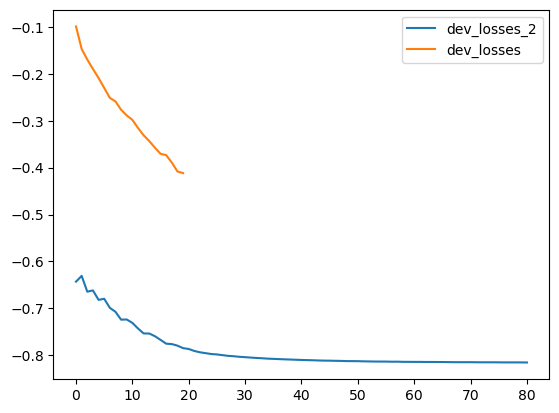

In [16]:
torch.save(model, 'models/model_12_1_channel_MSE_norm_data')
torch.save(torch.Tensor(train_losses), 'losses/train_losses_model_12')
torch.save(torch.Tensor(dev_losses), 'losses/dev_losses_model_12')
dev_losses_2 = torch.load('losses/dev_losses_model_9')
plt.plot(np.log10(dev_losses_2))
plt.plot(np.log10(dev_losses))
plt.legend(['dev_losses_2', 'dev_losses'])

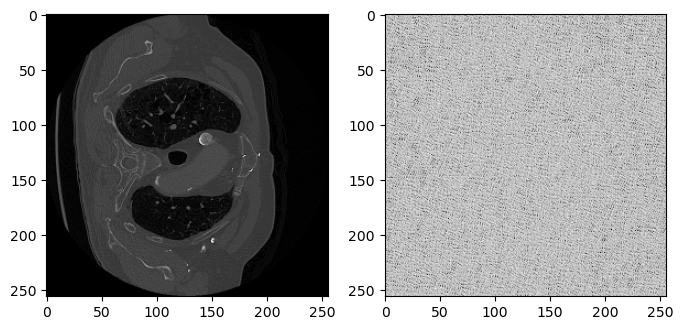

In [17]:
model.eval()
x_test = next(iter(dev_loader))[0].view(1, 256, 256).to(device)
#x_test = torch.zeros((1, 256, 256)).to(device)
x_hat_test = model.forward(x_test)[0]
draw(x_test.cpu(), x_hat_test.cpu())
#mse_loss(x_test, x_hat_test)
#x_sampled = model.decode(torch.randn(1, latent_size).to(device)).view(1, 256, 256).cpu()
#plt.imshow(x_sampled[0].detach().numpy(), cmap='gray')